Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "race1"

## Load Dataset

In [3]:
DATAFILE= "bar_pass_prediction.csv"

#learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster','zgpa','fulltime','fam_inc','Dropout','tier','gpa','pass_bar'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1.33,female,white
1,29.0,3.5,-0.11,female,white
2,36.0,3.5,-0.64,male,white
3,39.0,3.5,0.34,male,white
4,48.0,3.5,1.02,male,white


In [4]:
df.zfygpa = np.where(df.zfygpa >= df.zfygpa.median(),1,0)

In [5]:
indexRace = df[ (df['race1'] != 'black') & (df['race1'] != 'white') ].index
df.drop(indexRace , inplace=True)

In [6]:
df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1,female,white
1,29.0,3.5,0,female,white
2,36.0,3.5,0,male,white
3,39.0,3.5,1,male,white
4,48.0,3.5,1,male,white


## Model training and test

In [7]:
X = df.drop('zfygpa', axis=1)
y = df['zfygpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 31.2 ms
Wall time: 51.8 ms


array([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.])

In [9]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.63      0.44      0.52      2754
           1       0.60      0.76      0.67      3006

    accuracy                           0.61      5760
   macro avg       0.62      0.60      0.60      5760
weighted avg       0.61      0.61      0.60      5760



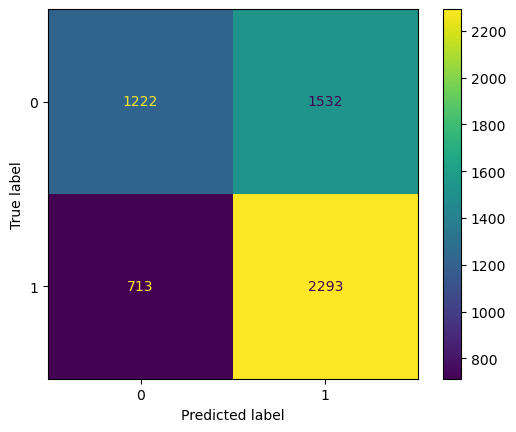

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='race1',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 76.47it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 5498.58it/s]

Computing correctenesses for all valid if-thens.



100%|█████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:09<00:00, 166.76it/s]

Number of if-thens: 1530


In [ ]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [12]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["white"][1][0][1]-e[1]["black"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If lsat = 28.0:
	Subgroup 'black', 6.43% covered
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 3.23% covered
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 39.0 with correctness 91.84%.
		Make lsat = 37.0 with correctness 81.63%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with correctness 100.00%.
		Make 

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [13]:
feature_weights = {"gender": 1, "race1": 1}
comparators = facts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 28.0:
	Subgroup 'black', 6.43% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Subgroup 'white', 3.23% covered out of 17921
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 39.0 with correctness 91.84%.
		Make lsat = 37.0 with correctness 81.63%.
		Make lsat = 42.0 with c

## Minimum cost above threshold

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
        top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 2.5:
	Subgroup 'black', 10.48% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 4.03% covered out of 17921
		Make ugpa = 3.4 with correctness 67.21%.
		Make ugpa = 3.5 with correctness 75.41%.
		Make ugpa = 3.6 with correctness 81.97%.
		Make ugpa = 3.3 with correctness 59.02%.
		Make ugpa = 3.7 with correctness 83.61%.
		Make ugpa = 3.2 with correctness 54.10%.
		Make ugpa = 3.8 with correctness 85.25%.
		Make ugpa = 3.9 with correctness 85.25%.
		Aggregate cost of the above recourses = 1.00
	Bias against black. Unfairness measure = inf.
If ugpa = 2.9:
	Subgroup 'black', 8.33% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 10.10% covered out of 17921
		Make ugpa = 3.4 with correctness 66.01%.
		Make ugpa = 3.5 with correctness 73.20%.
		Make ugpa = 3.6 with correctness 77.12%.
		Make ugpa = 3.3 with correctness 50.33%.
		Make ugpa = 3.

## Mean cost above threshold

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 2.5:
	Subgroup 'black', 10.48% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 4.03% covered out of 17921
		Make ugpa = 3.4 with correctness 67.21%.
		Make ugpa = 3.5 with correctness 75.41%.
		Make ugpa = 3.6 with correctness 81.97%.
		Make ugpa = 3.3 with correctness 59.02%.
		Make ugpa = 3.7 with correctness 83.61%.
		Make ugpa = 3.2 with correctness 54.10%.
		Make ugpa = 3.8 with correctness 85.25%.
		Make ugpa = 3.9 with correctness 85.25%.
		Aggregate cost of the above recourses = 1.00
	Bias against black. Unfairness measure = inf.
If ugpa = 2.9:
	Subgroup 'black', 8.33% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'white', 10.10% covered out of 17921
		Make ugpa = 3.4 with correctness 66.01%.
		Make ugpa = 3.5 with correctness 73.20%.
		Make ugpa = 3.6 with correctness 77.12%.
		Make ugpa = 3.3 with correctness 50.33%.
		Make ugpa = 3.

## Number above threshold

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race1"] == sg).sum() for sg in X["race1"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If gender = female, lsat = 28.0:
	Subgroup 'black', 4.76% covered out of 1279
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Subgroup 'white', 1.25% covered out of 17921
		Make gender = male, lsat = 40.0 with correctness 100.00%.
		Make gender = male, lsat = 39.0 with correctness 100.00%.
		Make gender = male, lsat = 42.0 with correctness 100.00%.
		Make gender = male, lsat = 37.0 with correctness 94.74%.
		Make gender = male, lsat = 36.0 with correctness 89.47%.
		Make gender = male, lsat = 41.0 with correctness 100.00%.
		Make gender = male, lsat = 38.0 with correctness 94.74%.
		Make lsat = 39.0 with correctness 94.74%.
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 41.0 with correctness 100.00%.
		Make lsat = 37.0 with correctness 78.95%.
		Make gender = male, lsat = 44.0 with correctness 100.00%.
		Make lsat = 38.0 with correctness 94.74%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 36.0 with correctness 78.95%.
		Make 

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


If lsat = 28.0:
	Subgroup 'black', 6.43% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 3.23% covered out of 17921
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 39.0 with correctness 91.84%.
		Make lsat = 37.0 with correctness 81.63%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with cor

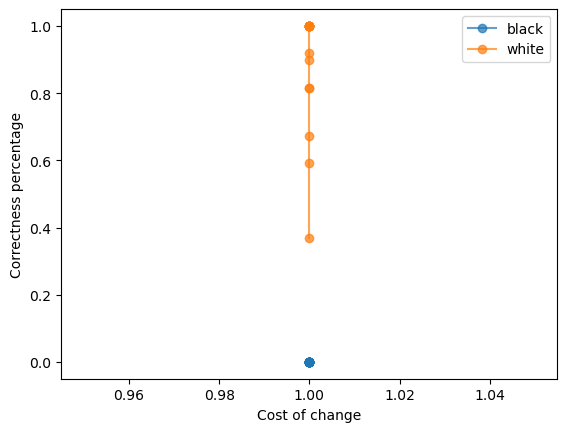

If lsat = 30.0:
	Subgroup 'black', 5.71% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 6.53% covered out of 17921
		Make lsat = 40.0 with correctness 98.99%.
		Make lsat = 39.0 with correctness 95.96%.
		Make lsat = 37.0 with correctness 84.85%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with corr

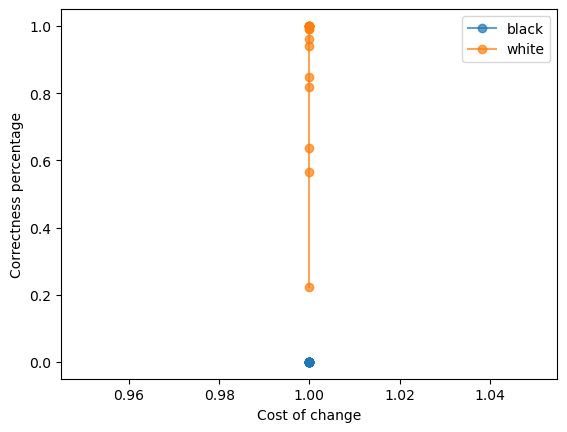

If lsat = 29.0:
	Subgroup 'black', 7.86% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 4.42% covered out of 17921
		Make lsat = 40.0 with correctness 98.51%.
		Make lsat = 39.0 with correctness 94.03%.
		Make lsat = 37.0 with correctness 82.09%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with corr

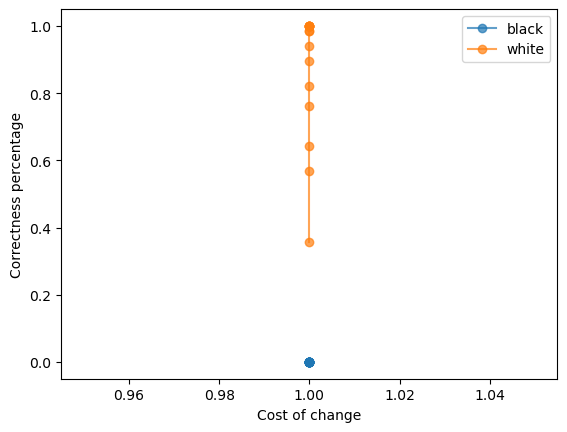

If lsat = 33.0:
	Subgroup 'black', 5.24% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
	Subgroup 'white', 12.61% covered out of 17921
		Make lsat = 40.0 with correctness 96.34%.
		Make lsat = 39.0 with correctness 92.15%.
		Make lsat = 37.0 with correctness 76.96%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with correctness 97.38%.
		Make lsat = 36.0 with co

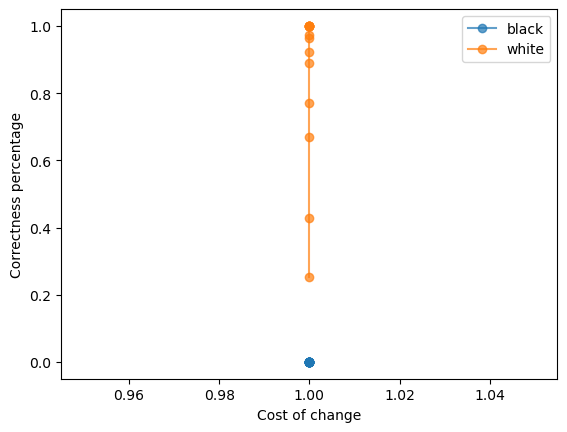

If lsat = 31.0:
	Subgroup 'black', 4.52% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 7.99% covered out of 17921
		Make lsat = 40.0 with correctness 98.35%.
		Make lsat = 39.0 with correctness 96.69%.
		Make lsat = 37.0 with correctness 78.51%.
		Make lsat = 42.0 with correctness 99.17%.
		Make lsat = 41.0 with corre

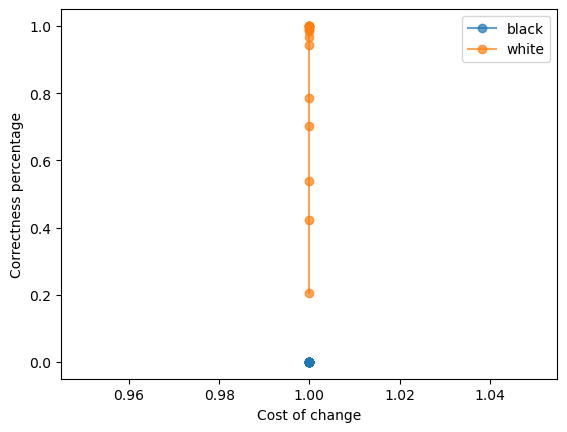

If lsat = 32.0:
	Subgroup 'black', 6.90% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 9.04% covered out of 17921
		Make lsat = 40.0 with correctness 97.81%.
		Make lsat = 39.0 with correctness 94.16%.
		Make lsat = 37.0 with correctness 78.10%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with corr

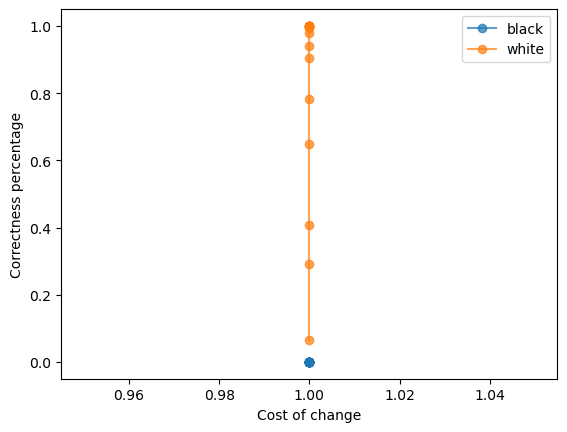

If lsat = 27.0:
	Subgroup 'black', 4.29% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 1.78% covered out of 17921
		Make lsat = 40.0 with correctness 100.00%.
		Make lsat = 39.0 with correctness 96.30%.
		Make lsat = 37.0 with correctness 48.15%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with cor

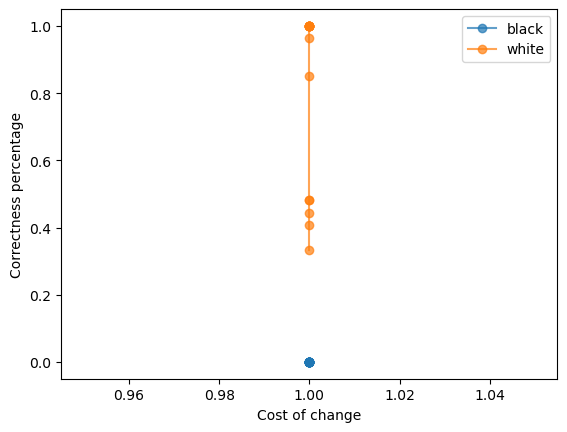

If lsat = 34.0:
	Subgroup 'black', 4.76% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 9.64% covered out of 17921
		Make lsat = 40.0 with correctness 96.58%.
		Make lsat = 39.0 with correctness 90.41%.
		Make lsat = 37.0 with correctness 63.70%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with correctness 97.95%.
		Make lsat = 36.0 with cor

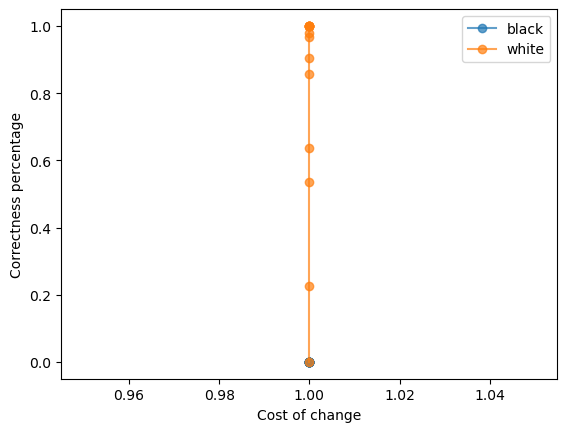

If lsat = 35.0:
	Subgroup 'black', 3.81% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 36.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 10.89% covered out of 17921
		Make lsat = 40.0 with correctness 98.18%.
		Make lsat = 39.0 with correctness 92.12%.
		Make lsat = 37.0 with correctness 63.03%.
		Make lsat = 42.0 with correctness 99.39%.
		Make lsat = 41.0 with correctness 98.79%.
		Make lsat = 36.0 with cor

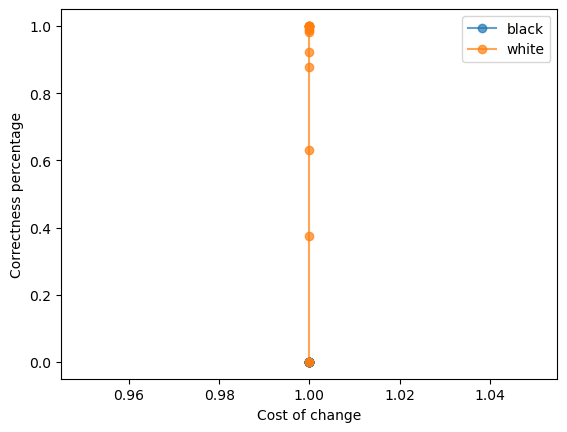

If lsat = 36.0:
	Subgroup 'black', 1.90% covered out of 1279
		Make lsat = 40.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 0.00%.
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 42.0 with correctness 0.00%.
		Make lsat = 41.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 0.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 0.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 0.00%.
		Make lsat = 47.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'white', 4.55% covered out of 17921
		Make lsat = 40.0 with correctness 91.30%.
		Make lsat = 39.0 with correctness 79.71%.
		Make lsat = 37.0 with correctness 28.99%.
		Make lsat = 42.0 with correctness 100.00%.
		Make lsat = 41.0 with correctness 98.55%.
		Make lsat = 38.0 with cor

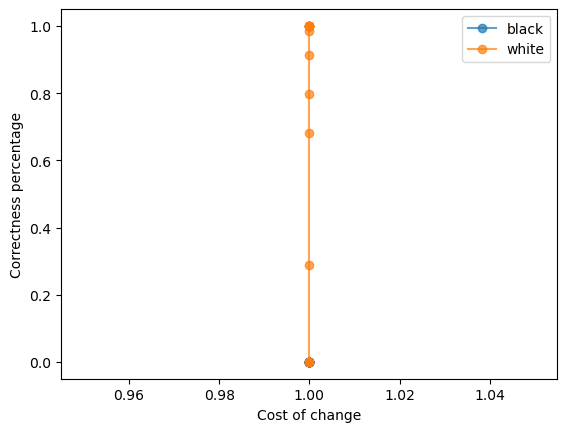

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = facts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [22]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)